In [1]:
import json
import glob
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import statistics
import numpy as np
import operator
import matplotlib.ticker as plticker

In [2]:
eval_files_list = glob.glob('**/eval_results*.json', recursive=True)

In [3]:
def get_data(eval_file_path):
    with open(eval_file_path, 'r') as f:
        data = json.loads(f.read())
    eval_data = {}
    eval_data["iteration"] = data["config"]["model_args"]["iteration"]
    eval_data["model_name"] = list(data["config"]["model_args"]["config_files"].keys())[0][:-4]
    eval_data["templates"] = tuple(set(data["table_results"][res]["prompt_name"] for res in data["table_results"].keys()))
    eval_data["tasks"] = tuple(set(data["table_results"][res]["task_name"] for res in data["table_results"].keys()))
    dct = defaultdict(list)
    for key, value in data["table_results"].items():
        task, template = key.split("+")
        dct[task].append((template, value["em"], value["em_stderr"]))
        #dct[template].append((task, value["em"], value["em_stderr"]))
    for template, value in dct.items():
        inner_dict = {}
        for task, em, em_stderr in value:
            inner_dict[task] = (em, em_stderr)
        dct[template] = inner_dict
    eval_data["results"] = dct
    return eval_data

In [4]:
data_lst = [get_data(eval_file) for eval_file in eval_files_list]

In [29]:
tasks = ["wino_bias_type1_pro", "wino_bias_type1_anti", "wino_bias_type2_pro", "wino_bias_type2_anti"]
templates = ["What does p stand for", "refers_to"]
model_sizes_dct = {
    "19M": "70M",
    "350M": "410M",
    "1.3B": "1.4B",
    "6.7B": "6.9B"
    }
model_sizes = model_sizes_dct.keys()
bb_iterations = sorted([eval["iteration"] for eval in data_lst if eval["model_name"] == "pythia-350M"])
sb_iterations = [3000, 13000, 23000, 33000, 43000, 53000, 63000, 73000, 83000, 93000, 103000, 113000, 123000, 133000, 143000]
iter_percents = ["{:.0f}".format((iter / bb_iterations[-1]) * 100) for iter in bb_iterations]

In [30]:
def eval_model_size(model_size):
    # return dict is a dict of dicts, where the first keys are the iterations
    # and the second keys are "type1" and "type2"
    proc_dct = {}
    final_results = {}
    for eval in data_lst:
        iteration = eval["iteration"]
        proc_dct[iteration] = {
            task: {} for task in tasks
        }
        if eval["model_name"] == f"pythia-{model_size}":
            for task, result_dct in eval["results"].items():
                mean = statistics.fmean([result_dct[template][0] for template in templates])
                std = math.sqrt(statistics.mean([result_dct[template][1]**2 for template in templates]))
                proc_dct[iteration][task] = (mean, std)
                # for template in templates:
                #     em_diff = result_dct[task + "_pro"][0] - result_dct[task + "_anti"][0]
                #     # Std of difference is sqrt(sum of variances)
                #     em_std = math.sqrt(result_dct[task + "_pro"][1]**2 + result_dct[task + "_anti"][1]**2)
                #     proc_dct[iteration][template][task] = (em_diff, em_std, result_dct[task + "_pro"][0], result_dct[task + "_anti"][0])
            type1_diff = proc_dct[iteration]["wino_bias_type1_pro"][0] - proc_dct[iteration]["wino_bias_type1_anti"][0]
            # Std of difference is sqrt(sum of variances)
            type1_err = math.sqrt(proc_dct[iteration]["wino_bias_type1_pro"][1]**2 + proc_dct[iteration]["wino_bias_type1_anti"][1]**2)
            type1_pro, type1_anti = proc_dct[iteration]["wino_bias_type1_pro"][0], proc_dct[iteration]["wino_bias_type1_anti"][0]
            type2_diff = proc_dct[iteration]["wino_bias_type2_pro"][0] - proc_dct[iteration]["wino_bias_type2_anti"][0]
            type2_err = math.sqrt(proc_dct[iteration]["wino_bias_type2_pro"][1]**2 + proc_dct[iteration]["wino_bias_type2_anti"][1]**2)
            type2_pro, type2_anti = proc_dct[iteration]["wino_bias_type2_pro"][0], proc_dct[iteration]["wino_bias_type2_anti"][0]
            type1 = (type1_diff, type1_err, type1_pro, type1_anti)
            type2 = (type2_diff, type2_err, type2_pro, type2_anti)
                
            final_results[iteration] = {
                "type1": type1,
                "type2": type2 
            }
    return final_results

In [31]:
all_results = {size: eval_model_size(size) for size in model_sizes}

In [32]:
def get_lists_for_plotting(model_size, type):
    res_lists = {
        "diffs": [],
        "errs": [],
        "pro": [],
        "anti": [],
    }
    if model_size == "19M" or model_size == "6.7B":
        iterations = sb_iterations
    else:
        iterations = bb_iterations
    for iteration in iterations:
        diff, err, pro_em, anti_em = all_results[model_size][iteration][type]
        res_lists["diffs"].append(diff)
        res_lists["errs"].append(err)
        res_lists["pro"].append(pro_em)
        res_lists["anti"].append(anti_em)
    return res_lists

Text(0.5, 1.0, 'Winobias')

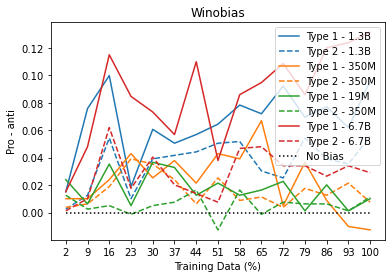

In [33]:
res_dct = get_lists_for_plotting("1.3B", "type1")
diffs, errs, pro, anti = operator.itemgetter(*res_dct.keys())(res_dct)

plt.plot(iter_percents, diffs, label = "Type 1 - 1.3B", color="C0")
#plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], alpha=0.2, color="C0")

res_dct = get_lists_for_plotting("1.3B", "type2")
diffs, errs, pro, anti = operator.itemgetter(*res_dct.keys())(res_dct)

plt.plot(iter_percents, diffs, label="Type 2 - 1.3B", linestyle="--", color="C0")
#plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], alpha=0.2, color="C0")

res_dct = get_lists_for_plotting("350M", "type1")
diffs, errs, pro, anti = operator.itemgetter(*res_dct.keys())(res_dct)

plt.plot(iter_percents, diffs, label = "Type 1 - 350M", color="C1")
#plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], alpha=0.2, color="C1")

res_dct = get_lists_for_plotting("350M", "type2")
diffs, errs, pro, anti = operator.itemgetter(*res_dct.keys())(res_dct)

plt.plot(iter_percents, diffs, label="Type 2 - 350M", linestyle="--", color="C1")
#plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], alpha=0.2, color="C1")

res_dct = get_lists_for_plotting("19M", "type1")
diffs, errs, pro, anti = operator.itemgetter(*res_dct.keys())(res_dct)

plt.plot(iter_percents, diffs, label = "Type 1 - 19M", color="C2")
#plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], alpha=0.2, color="C2")

res_dct = get_lists_for_plotting("19M", "type2")
diffs, errs, pro, anti = operator.itemgetter(*res_dct.keys())(res_dct)

plt.plot(iter_percents, diffs, label="Type 2 - 350M", linestyle="--", color="C2")
#plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], alpha=0.2, color="C2")

res_dct = get_lists_for_plotting("6.7B", "type1")
diffs, errs, pro, anti = operator.itemgetter(*res_dct.keys())(res_dct)

plt.plot(iter_percents, diffs, label = "Type 1 - 6.7B", color="C3")
#plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], alpha=0.2, color="C3")

res_dct = get_lists_for_plotting("6.7B", "type2")
diffs, errs, pro, anti = operator.itemgetter(*res_dct.keys())(res_dct)

plt.plot(iter_percents, diffs, label="Type 2 - 6.7B", linestyle="--", color="C3")

plt.plot(iter_percents, [0 for _ in iter_percents], linestyle=":", color="black", label="No Bias")

plt.legend()
plt.xlabel("Training Data (%)")
#plt.ylim(-0.1, 0.1)
plt.ylabel("Pro - anti")
plt.title("Winobias")
#plt.savefig("winobias.png")

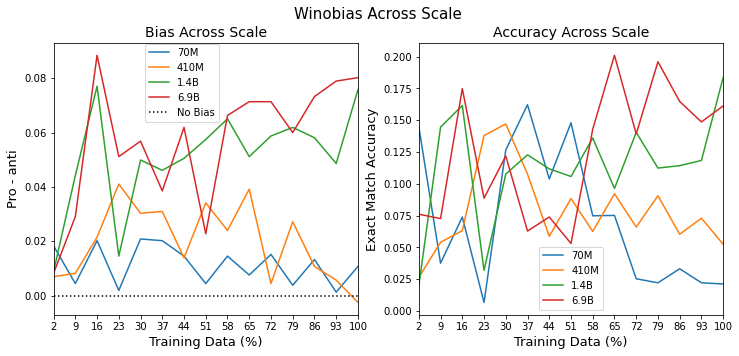

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for size in model_sizes:
    type1 = get_lists_for_plotting(size, "type1")
    type2 = get_lists_for_plotting(size, "type2")
    pro = np.mean([type1["pro"], type2["pro"]], axis=0)
    anti = np.mean([type1["anti"], type2["anti"]], axis=0)
    diff = pro - anti
    ax[0].plot(iter_percents, diff, label=model_sizes_dct[size])
    ax[1].plot(iter_percents, np.mean([pro, anti], axis=0), label=model_sizes_dct[size])

ax[0].plot(iter_percents, [0 for _ in iter_percents], linestyle=":", color="black", label="No Bias")

for i in range(len(ax)):
    ax[i].set_xlabel("Training Data (%)", fontsize=13)
    if i == 0:
        ax[i].legend(loc=(0.30, 0.71))
        ax[i].set_ylabel("Pro - anti", fontsize=13)
        metric_str = "Bias"
    else:
        ax[i].legend(loc="lower center")
        ax[1].set_ylabel("Exact Match Accuracy", fontsize=13)
        metric_str = "Accuracy"
    ax[i].title.set_text(f'{metric_str} Across Scale')
    ax[i].title.set_fontsize(14)
    ax[i].set_xlim(0, 14)

fig.suptitle("Winobias Across Scale", fontsize=15)
for i in range(len(ax)):
    ax[i].set_xlim(0, 14)
fig.savefig("winobias_scale.pdf")